# Zero-index Bound states In the Continuum

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import autograd.numpy as npa
from autograd import grad, value_and_grad

import legume
from legume.minimize import Minimize
from legume.utils import grad_num

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Daisy-hole PhC simulation

In this Notebook, we will have a look at the photonic crystal slab of Minkov et al., PRL 121, 263901 (2018). Curious note: for some reason the abbreviation of bound states in the continuum is BIC and not BSC. Go figure.

The `FourierShape` class in `legume` allows us to add shapes defined by their position `x_cent`, `y_cent`, and the Fourier coefficients of polar coordinates of the shape, i.e. the discrete Fourier transform of `r(phi)`.

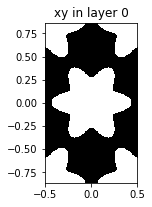

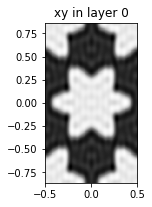

In [2]:
# Define a PhC with a "daisy" hole shape.
# This takes the 6-th Fourier coefficient so as to preserve the C6 symmetry.
lattice = legume.Lattice('hexagonal')
def daisy_phc(d, r0, rd):
    """
    d: slab thikcness
    r0, rd: base radius and radius modulation as defined in the paper
    """
    phc = legume.PhotCryst(lattice)
    phc.add_layer(d=d, eps_b=12)

    # We implement the daisy as a FourierShape class
    f_as = np.array([2*r0, 0, 0, 0, 0, 0, rd])
    daisy = legume.FourierShape(x_cent=0, y_cent=0, f_as=f_as)
    phc.add_shape(daisy) 
    return phc

phc = daisy_phc(0.5, 0.35, 0.08)    # parameters of the paper
gme = legume.GuidedModeExp(phc, gmax=5)

# We can have a look at the structure as defined and obtained from an inverse FT
legume.viz.structure(phc, figsize=2., cbar=False, Nx=200, Ny=300)
legume.viz.eps_ft(gme, figsize=2., cbar=False, Nx=200, Ny=300)

Now let's run the simulation and confirm we have the nice Dirac cone + BIC effect at the $\Gamma$-point. 

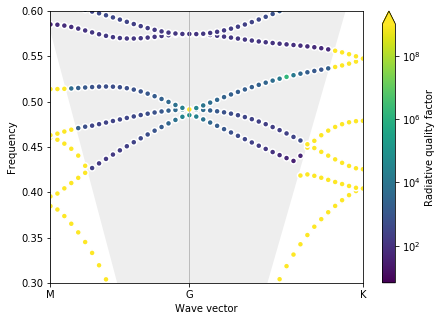

In [3]:
path = lattice.bz_path(['M', 'G', 'K'], [20, 25])
options = {'gmode_inds': [1, 2], 'numeig': 20, 'verbose': False}

gme.run(kpoints=path['kpoints'], **options)

def plot_bands(gme):
    fig, ax = plt.subplots(1, figsize = (7, 5))
    legume.viz.bands(gme, Q=True, ax=ax)
    ax.set_xticks(path['indexes'])
    ax.set_xticklabels(path['labels'])
    ax.xaxis.grid('True')
    ax.set_ylim([0.3,0.6])
    
plot_bands(gme)

Note: for speed, in this Notebook we are using using `gmax = 5` and `gmode_inds = [1, 2]` (note that we're looking at the quasi-TM modes). Increasing `gmax = 6` and `gmode_inds = [1, 2, 4]` will reveal an even closer degenracy of the bands.

## Finding optimal parameters

The idea of the paper is that the first three modes at $\Gamma$ are guaranteed to be BICs by symmetry. So the only thing that has to be tuned is the accidental degeneracy, in order to get the Dirac cone. When writing the paper, this was done using GME, but tuning the parameters by hand (`legume` did not yet exist). Let's try to use an optimization instead! 

First, let's look at a starting structure with just circular holes.

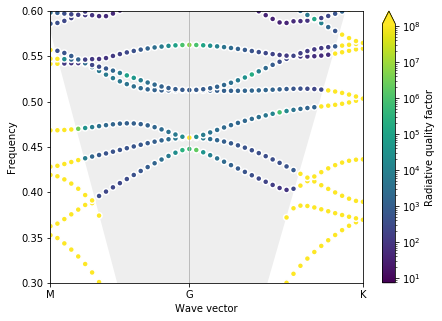

In [4]:
phc = daisy_phc(0.5, 0.3, 0.0)  
gme = legume.GuidedModeExp(phc, gmax=5)
gme.run(kpoints=path['kpoints'], **options)
plot_bands(gme)

## Test gradient

In [5]:
# To compute gradients, we need to set the `legume` backend to 'autograd'
legume.set_backend('autograd')
    
# Objective function is the difference in frequency between modes 1 and 3
# Mode 2 is by symmetry degenerate with either 1 or 3
def of_daisy(params):
    d = params[0]
    r0 = params[1]
    rd = params[2]

    phc = daisy_phc(d, r0, rd)
    gme = legume.GuidedModeExp(phc, gmax=5)
    gme.run(kpoints=np.array([[0], [0]]), **options)

    return gme.freqs[0, 3] - gme.freqs[0, 1]

pstart = np.array([0.5, 0.3, 0.])
obj_grad = value_and_grad(of_daisy)

# Compute the autograd gradients (NB: all at once!)
grad_a = obj_grad(pstart)[1]
print("Autograd gradient w.r.t. d, r0, rd:   ", grad_a)

# Compute a numerical gradient 
grad_n = grad_num(of_daisy, pstart)
print("Numerical gradient w.r.t. d, r0, rd:  ", grad_n)

Autograd gradient w.r.t. d, r0, rd:    [-0.0048997   0.05159475 -0.07417041]
Numerical gradient w.r.t. d, r0, rd:   [-0.00489965  0.05159477 -0.07417045]


## Optimization of circular holes
We will first restrict the optimization to circular holes, only changing the slab thickness circular hole radius (setting $r_d = 0$).

In [6]:
def of_d_r(params):
    p_daisy = npa.array(list(params) + [0.])
    return of_daisy(p_daisy)

opt = Minimize(of_d_r)

# Starting parameters d and r0
pstart = npa.array([0.5, 0.3])
# Bounds on the parameters
bounds=[(0.1, 1), (0.1, 0.45)]

# Run an 'lbfgs' optimization
(p_opt, ofs) = opt.lbfgs(pstart, Nepochs=10, bounds=bounds)

Epoch:    1/  10 | Duration:   5.30 secs | Objective: 9.322272e-03
Epoch:    2/  10 | Duration:   5.09 secs | Objective: 5.852986e-04
Epoch:    3/  10 | Duration:   7.64 secs | Objective: 4.665987e-04
Epoch:    4/  10 | Duration:   2.55 secs | Objective: 2.889001e-04
Epoch:    5/  10 | Duration:   2.74 secs | Objective: 2.468087e-04


Optimal parameters found are d = 1.00, r0 = 0.10


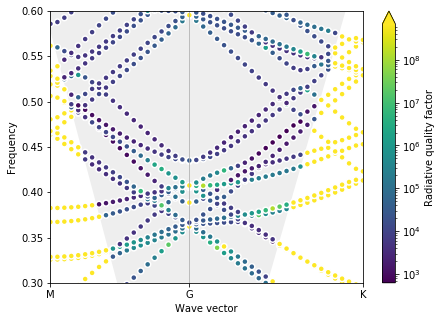

In [7]:
# Print optimal parameters and visualize PhC bands
print("Optimal parameters found are d = %1.2f, r0 = %1.2f" %(p_opt[0], p_opt[1]))
phc = daisy_phc(p_opt[0], p_opt[1], 0.0)  
gme = legume.GuidedModeExp(phc, gmax=5)
gme.run(kpoints=path['kpoints'], **options)
plot_bands(gme)

The optimization converged to the edge of the bounds, and, even though there is obviously a triple degeneracy, the bands are not very useful to us. Specifically, the Dirac cone is degenrate with many other bands, making the zero-index effect hard to use. We can try to make the bounds on the slab thickness more restrictive.

In [8]:
bounds=[(0.4, 0.6), (0.1, 0.45)]
(p_opt, ofs) = opt.lbfgs(pstart, Nepochs=10, bounds=bounds)

Epoch:    1/  10 | Duration:   5.28 secs | Objective: 9.322272e-03
Epoch:    2/  10 | Duration:   5.05 secs | Objective: 5.852986e-04
Epoch:    3/  10 | Duration:   7.55 secs | Objective: 4.996387e-04


Optimal parameters found are d = 0.60, r0 = 0.10


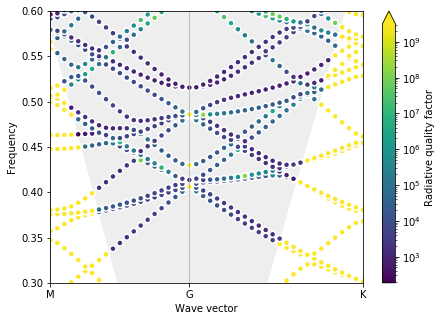

In [9]:
print("Optimal parameters found are d = %1.2f, r0 = %1.2f" %(p_opt[0], p_opt[1]))
phc = daisy_phc(p_opt[0], p_opt[1], 0.0)  
gme = legume.GuidedModeExp(phc, gmax=5)
gme.run(kpoints=path['kpoints'], **options)
plot_bands(gme)

This, however, still drives the radius to its minimum allowed value, and the Dirac cone is not very "clean". This is why we introduced the $r_d$ parameter in the PRL paper. As mentioned above, the parameters there were optimized by hand, but we can run one final automatic optimization here that gives us a good structure.

In [10]:
# This time include all three parameters
opt = Minimize(of_daisy)
pstart = npa.array([0.5, 0.4, 0.])
bounds=[(0.4, 0.6), (0.3, 0.45), (-0.1, 0.1)]

(p_opt, ofs) = opt.lbfgs(pstart, Nepochs=10, bounds=bounds)

Epoch:    1/  10 | Duration:   5.45 secs | Objective: 6.930302e-03
Epoch:    2/  10 | Duration:  19.11 secs | Objective: 3.413816e-04
Epoch:    3/  10 | Duration:  12.75 secs | Objective: 5.787761e-05
Epoch:    4/  10 | Duration:  40.83 secs | Objective: 4.805000e-05
Epoch:    5/  10 | Duration:  23.96 secs | Objective: 4.785463e-05
Epoch:    6/  10 | Duration:  31.78 secs | Objective: 4.784765e-05


Optimal parameters found are d = 0.45, r0 = 0.35, rd = 0.10


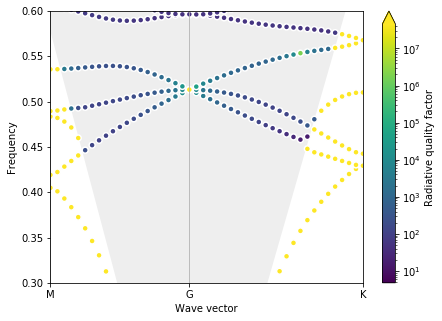

In [11]:
print("Optimal parameters found are d = %1.2f, r0 = %1.2f, rd = %1.2f" %(p_opt[0], p_opt[1], p_opt[2]))
phc = daisy_phc(p_opt[0], p_opt[1], p_opt[2])  
gme = legume.GuidedModeExp(phc, gmax=5)
gme.run(kpoints=path['kpoints'], **options)
plot_bands(gme)

This finally gives us a nice clean Dirac cone and one set of parameters for our low-loss zero-index PhC! Finally, let's have a look at what it looks like.

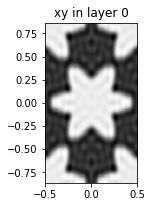

In [12]:
legume.viz.eps_ft(gme, figsize=2., cbar=False, Nx=200, Ny=300)